In [1]:
# import project data prep helpers
import sys
sys.path.append('/Users/samrelins/Documents/LIDA/dental_project/src/')
from data_prep import *

from causalnex.structure.notears import from_pandas
from causalnex.discretiser import Discretiser
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE
from causalnex.network import BayesianNetwork
from IPython.display import Image
import plotly.express as px
from sklearn.model_selection import train_test_split


data_dir = "/Users/samrelins/Documents/LIDA/dental_project/data/erin_data"

ga_data, epi_data = build_epi_ga_data(data_dir)
ga_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1077 entries, 0 to 1076
Data columns (total 73 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age_at_ga                1077 non-null   float64
 1   type_of_ga               1077 non-null   object 
 2   total_ga                 1077 non-null   float64
 3   ga_sequence              1077 non-null   float64
 4   weight_at_ga             909 non-null    float64
 5   ur6                      1077 non-null   object 
 6   urE                      1077 non-null   object 
 7   urd                      1077 non-null   object 
 8   urc                      1077 non-null   object 
 9   urb                      1077 non-null   object 
 10  ura                      1077 non-null   object 
 11  ula                      1077 non-null   object 
 12  ulb                      1077 non-null   object 
 13  ulc                      1077 non-null   object 
 14  uld                     

### Simple DAG describing No of Extractions

select subsamples of features that are relatively independent of one another and have decent number of observations

i.e. choose "ethnicity" to represent "ethnicity" / mother_ethnicity" / "mother_birthplace"

prep for use with causalnex library - drop nas and represent categorical features as numerical encoding

In [3]:
# prep data for simple DAG
dag_features = ['age_at_ga', 'type_of_ga', 'ethnicity', 'special_ed_needs',
                'imd_2010_decile', 'n_extracted']

# drop unnecessary cols and na vals from numeric features
encoded_data = ga_data[dag_features].copy()
encoded_data.dropna(inplace=True)
encoded_data.info()

# numerically encode categorical features
for col in encoded_data.columns:
    if encoded_data[col].dtype == np.dtype("object"):
        encoded_data[col] = encoded_data[col].astype("category").cat.codes

<class 'pandas.core.frame.DataFrame'>
Int64Index: 824 entries, 0 to 1070
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age_at_ga         824 non-null    float64
 1   type_of_ga        824 non-null    object 
 2   ethnicity         824 non-null    object 
 3   special_ed_needs  824 non-null    object 
 4   imd_2010_decile   824 non-null    float64
 5   n_extracted       824 non-null    float64
dtypes: float64(3), object(3)
memory usage: 45.1+ KB


## Infer Network Structure

start by getting causalnex to infer network structure from data

/opt/anaconda3/envs/DentalEnv/lib/python3.8/site-packages/pygraphviz/agraph.py:1390: RuntimeWarning: Warning: node 'age_at_ga', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


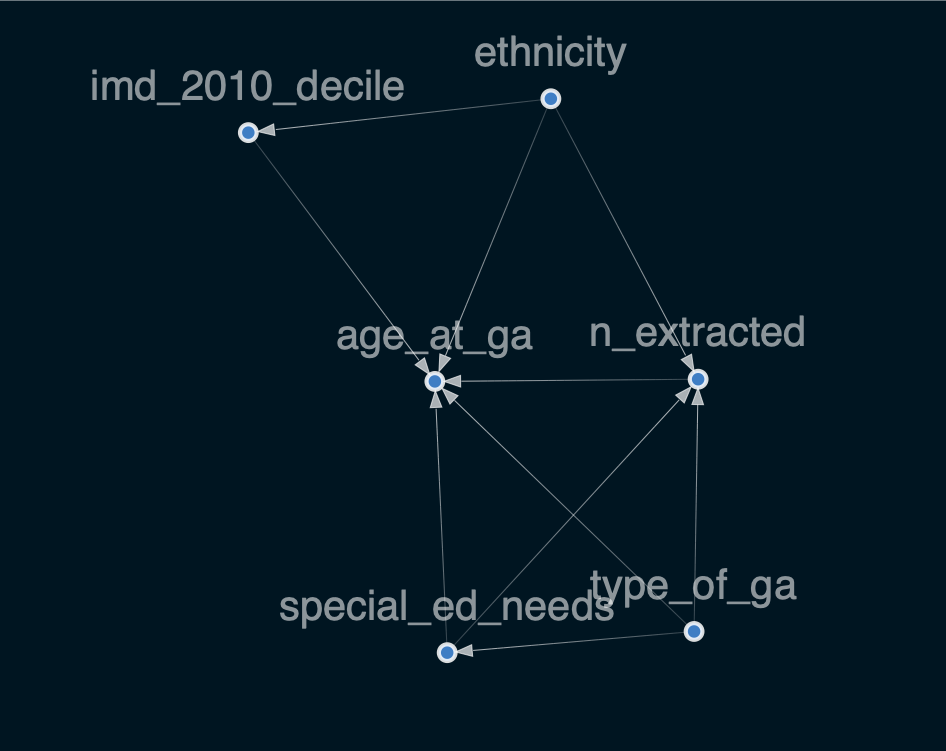

In [4]:
sm = from_pandas(encoded_data)

sm.remove_edges_below_threshold(0.8)
viz = plot_structure(
    sm,
    graph_attributes={"scale": "1"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK
)

Image(viz.draw(format="png"))

some edges intuitively incorrect i.e. several features purport to cause the age feature

other relationships we know - i.e. age_at_ga can cause type_of_ga, likewise "special_ed_needs" affects "type_of_ga"

encode this knowledge into graph and re-run structure learning

/opt/anaconda3/envs/DentalEnv/lib/python3.8/site-packages/pygraphviz/agraph.py:1390: RuntimeWarning: Warning: node 'age_at_ga', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


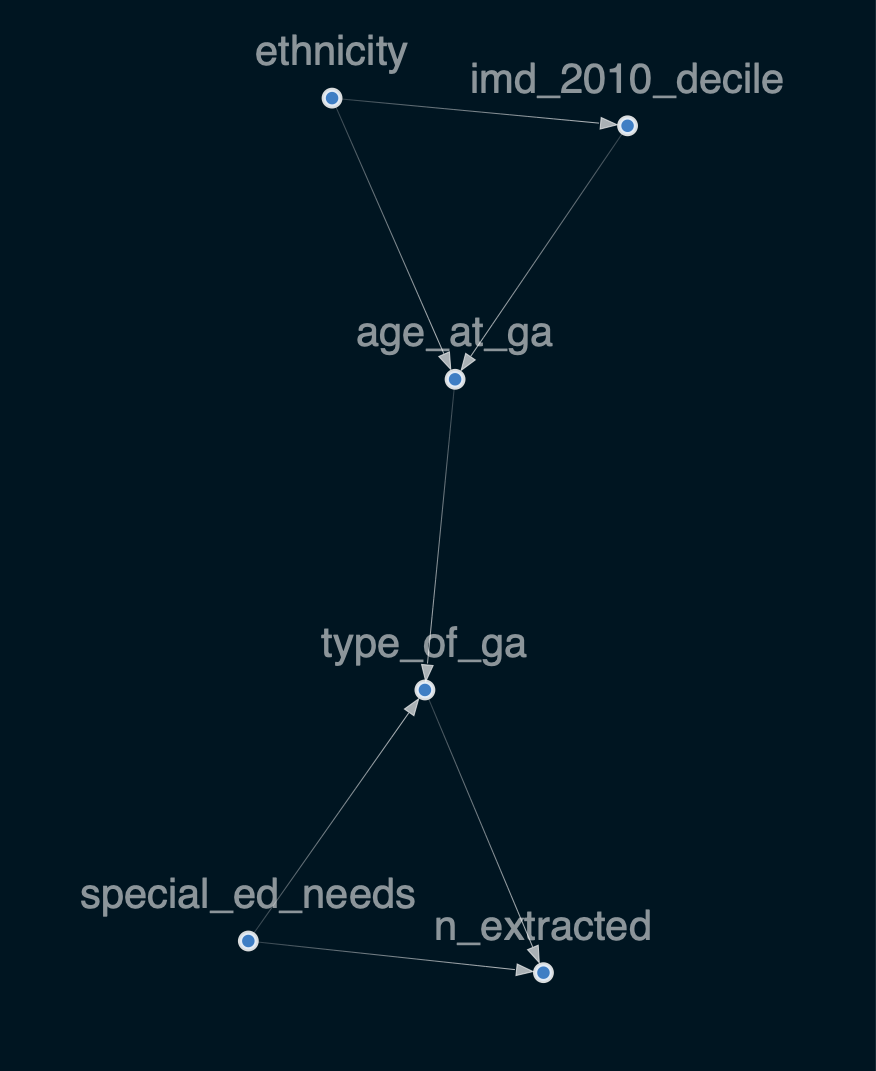

In [5]:
sm = from_pandas(encoded_data,
                 tabu_edges=[("n_extracted", "age_at_ga"),
                             ("type_of_ga", "age_at_ga"),
                             ("type_of_ga", "special_ed_needs"),
                             ("type_of_ga", "imd_2010_decile"),
                             ("special_ed_needs", "age_at_ga"),
                             ("special_ed_needs", "ethnicity"),
                             ("type_of_ga", "ethnicity"),
                             ("type_of_ga", "special_ed_needs")],
                 w_threshold=0.8)

sm.add_edge("age_at_ga", "type_of_ga")
sm.add_edge("special_ed_needs", "type_of_ga")
sm.add_edge("type_of_ga", "n_extracted")

viz = plot_structure(
    sm,
    graph_attributes={"scale": "1"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK
)

Image(viz.draw(format="png"))

## Train Network

use network to train parameters and run inference

first have to discretise data so probability tables can be calculated - can't construct tables with continous data, as every possible value of each variable needs value in prob tables

In [8]:
discretised_data = ga_data[dag_features].copy()
discretised_data.dropna(inplace=True)
discretised_data.reset_index(drop=True, inplace=True)

age_map = {0: "under_4", 1: "mid", 2: "over_8"}
discretised_data["age_at_ga"] = pd.Series(
    Discretiser(method="fixed",
                numeric_split_points=[48, 96])
        .transform(discretised_data.age_at_ga.values)
).map(age_map)

ext_map = {0: "less_than_7", 1: "mid", 2: "more_than_10"}
discretised_data["n_extracted"] = pd.Series(
    Discretiser(method="fixed",
                numeric_split_points=[7, 11])
        .transform(discretised_data.n_extracted.values)
).map(ext_map)

imd_map = {0: "imd_1", 1: "imd_1+"}
discretised_data["imd_2010_decile"] = pd.Series(
    Discretiser(method="fixed",
                numeric_split_points=[2])
        .transform(discretised_data.imd_2010_decile.values)
).map(imd_map)

split data into training & test set and train network

In [9]:
train, test = train_test_split(discretised_data, train_size=0.8, test_size=0.2)
bn = BayesianNetwork(sm)

bn.fit_node_states(discretised_data)
bn = bn.fit_cpds(train, method="BayesianEstimator", bayes_prior="K2")

can then view inferred conditional probability tables for any variable of interest

In [10]:
bn.cpds["n_extracted"]

special_ed_needs               EHCP                      Not SEN            \
type_of_ga       comprehensive_care exodontia comprehensive_care exodontia   
n_extracted                                                                  
less_than_7                0.473684     0.375           0.384615  0.273608   
mid                        0.368421     0.375           0.423077  0.428571   
more_than_10               0.157895     0.250           0.192308  0.297821   

special_ed_needs        SEN Support            
type_of_ga       comprehensive_care exodontia  
n_extracted                                    
less_than_7                0.421053  0.273438  
mid                        0.421053  0.445312  
more_than_10               0.157895  0.281250

can also run inference over variables in network:

In [12]:
from causalnex.inference import InferenceEngine

ie = InferenceEngine(bn)
marginals = ie.query()
marginals["n_extracted"]

{'less_than_7': 0.301754516836345,
 'mid': 0.4272168768400536,
 'more_than_10': 0.27102860632360143}

In [13]:
marginals_uk = ie.query({"ethnicity": "White British"})
print("=" * 80)
print("Marginal n_extracted | White British:\n")
print(marginals_uk['n_extracted'])

marginals_pak = ie.query({"ethnicity": "Pakistani"})
print("=" * 80)
print("Marginal n_extracted | White British:\n")
print(marginals_pak['n_extracted'])

Marginal n_extracted | White British:

{'less_than_7': 0.3014943723281049, 'mid': 0.4272330383415575, 'more_than_10': 0.2712725893303376}
Marginal n_extracted | White British:

{'less_than_7': 0.30195810101547427, 'mid': 0.4272043290054203, 'more_than_10': 0.2708375699791055}


In [14]:
marginals_uk = ie.query({"ethnicity": "White British",
                         "imd_2010_decile": "imd_1"})
print("=" * 80)
print("Marginal n_extractions | White British:\n")
print(marginals_uk['n_extractions'])

marginals_pak = ie.query({"ethnicity": "Pakistani",
                          "imd_2010_decile": "imd_1"})
print("=" * 80)
print("Marginal n_extractions | White British:\n")
print(marginals_pak['n_extractions'])

Marginal n_extractions | White British:



KeyError: 'n_extractions'

## Evaluate Network

all well and good, but also should evaluate network predictive performance on unseen data:

In [ ]:
from causalnex.evaluation import classification_report
classification_report(bn, test, "n_extractions")

In [17]:
test = test.join(bn.predict_probability(test, "n_extracted"))
pred_cols = ['n_extractions_more_than_10', 'n_extractions_less_than_7',
             'n_extractions_mid']
preds_df = (test[pred_cols + ["n_extractions"]]
            .groupby("n_extractions").agg(["mean", "sem"])
            .reset_index()
            .melt(id_vars="n_extracted")
            .pivot(index=["n_extracted", "variable_0"],
                   columns="variable_1", values="value")
            .reset_index()
            )

fig = px.line(preds_df,
              x="n_extracted",
              y="mean",
              color="variable_0",
              error_y="sem")
fig.show()

ValueError: columns overlap but no suffix specified: Index(['n_extracted_more_than_10', 'n_extracted_less_than_7',
       'n_extracted_mid'],
      dtype='object')

Not great!